### CustomTransferFunction
目前来看没什么用，但曾经有过用，故暂时保存 2024年10月21日

In [14]:
from scipy import signal
import numpy as np

class CustomTransferFunction(signal.TransferFunction):
    def __mul__(self, other):
        if isinstance(other, CustomTransferFunction):
            # 相乘后的分子和分母多项式
            new_num = np.polymul(self.num, other.num)
            new_den = np.polymul(self.den, other.den)
            return CustomTransferFunction(new_num, new_den)
        else:
            raise ValueError("Multiplication is only supported between TransferFunction instances")

# 测试自定义传递函数类
if __name__ == "__main__":
    # 定义三个传递函数的分子和分母多项式系数
    sys_TIA_num = [1, 2]
    sys_TIA_den = [1, 3, 2]
    sys_Crystal_num = [2, 5]
    sys_Crystal_den = [1, 4, 3]
    sys_SiPM_num = [1, 0]
    sys_SiPM_den = [1, 1]

    # 创建传递函数实例
    sys_TIA = CustomTransferFunction(sys_TIA_num, sys_TIA_den)
    sys_Crystal = CustomTransferFunction(sys_Crystal_num, sys_Crystal_den)
    sys_SiPM = CustomTransferFunction(sys_SiPM_num, sys_SiPM_den)

    # 使用 * 操作符进行传递函数相乘
    sys_total = sys_TIA * sys_Crystal * sys_SiPM

    # 打印结果
    print("sys_TIA(s):", sys_TIA)
    print("sys_Crystal(s):", sys_Crystal)
    print("sys_SiPM(s):", sys_SiPM)
    print("sys_total(s):", sys_total)

    # 创建传递函数实例
    sys_TIA = signal.TransferFunction(sys_TIA_num, sys_TIA_den)
    sys_Crystal = signal.TransferFunction(sys_Crystal_num, sys_Crystal_den)
    sys_SiPM = signal.TransferFunction(sys_SiPM_num, sys_SiPM_den)

    # 使用 * 操作符进行传递函数相乘
    sys_total = sys_TIA * sys_Crystal * sys_SiPM

    # 打印结果
    print("sys_TIA(s):", sys_TIA)
    print("sys_Crystal(s):", sys_Crystal)
    print("sys_SiPM(s):", sys_SiPM)
    print("sys_total(s):", sys_total)


sys_TIA(s): CustomTransferFunction(
array([1., 2.]),
array([1., 3., 2.]),
dt: None
)
sys_Crystal(s): CustomTransferFunction(
array([2., 5.]),
array([1., 4., 3.]),
dt: None
)
sys_SiPM(s): CustomTransferFunction(
array([1., 0.]),
array([1., 1.]),
dt: None
)
sys_total(s): CustomTransferFunction(
array([ 2.,  9., 10.,  0.]),
array([ 1.,  8., 24., 34., 23.,  6.]),
dt: None
)
sys_TIA(s): TransferFunctionContinuous(
array([1., 2.]),
array([1., 3., 2.]),
dt: None
)
sys_Crystal(s): TransferFunctionContinuous(
array([2., 5.]),
array([1., 4., 3.]),
dt: None
)
sys_SiPM(s): TransferFunctionContinuous(
array([1., 0.]),
array([1., 1.]),
dt: None
)
sys_total(s): TransferFunctionContinuous(
array([ 2.,  9., 10.,  0.]),
array([ 1.,  8., 24., 34., 23.,  6.]),
dt: None
)


### 超简配的SNR_calculator
韬哥matlab代码的直接迁移版

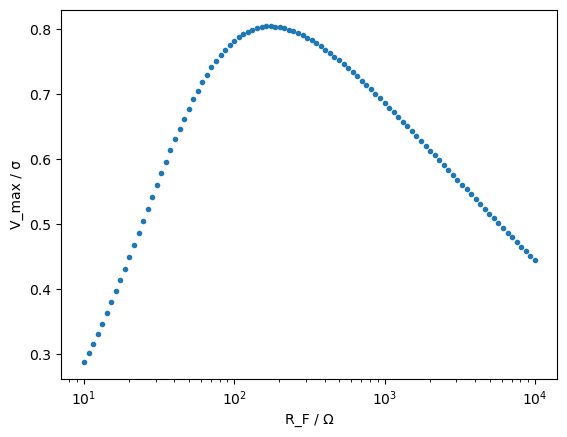

The best result is:
Output pulse height over baseline stdev is 0.8043754603458777 @174.7528400007683Ω
Feedback Capacitance is 264.4982516501801pF @174.7528400007683Ω
-3dB Bandwidth is 4.869541611920183MHz @174.7528400007683Ω


In [15]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# 定义SiPM类
class SiPM:
    def __init__(self, type_SiPM, V_OV):
        self.type_SiPM = type_SiPM
        self.V_OV = V_OV
        self.set_parameters()
    
    def set_parameters(self):
        if self.type_SiPM == "60035":
            self.C_SiPM = 4.14e-9  # SiPM阳极电容 F
            self.Gain = (self.V_OV + 0.4) * 1e6  # SiPM增益
            self.A_SiPM = 6.07 * 6.07  # SiPM有效面积 mm^2
            self.tau_SiPM = 50e-9  # SiPM恢复时间常数 s
            self.DCR_SiPM = np.exp(0.3139 * self.V_OV + 3.1273) * 1e3  # SiPM暗计数率 Hz/mm^2 忘了从哪找来的指数拟合
        else:
            raise ValueError(f"No performance parameters for SiPM type {self.type_SiPM}.")


n_SiPM = 2
type_SiPM = "60035"
V_OV = 6
sipm = SiPM(type_SiPM, V_OV)

R_F = np.logspace(1, 4, 100)  # 反馈电阻阻值 Ω
C_extra = (250 + 300) * 1e-12  # 额外附加的电容 F

tau_crystal = 70e-9  # 闪烁体发光衰减时间 s
extra_DCR = 0  # 附加的暗计数率 Hz

# 闪烁体传递函数
sys_Crystal = signal.TransferFunction([1], [tau_crystal, 1])

C_PCB = 0.3e-12  # PCB分布电容 F
C_CM = 0.7e-12  # 运放共模输入电容 F
C_DIFF = 2.8e-12  # 运放差模输入电容 F
GBP = 230e6  # 运放增益带宽积 Hz
I_N = 1.3e-15  # 运放输入电流噪声 A/√Hz
E_N = 7e-9  # 运放输入电压噪声 V/√Hz
A_OL = 10**(65/20)  # 运放开环增益
omega_A = 2 * np.pi * GBP / A_OL  # 运放开环增益的带宽（角频率） rad/s

C_D = n_SiPM * sipm.C_SiPM + C_PCB + C_CM + C_DIFF + C_extra  # 输入端总电容 F

e = 1.6e-19  # 元电荷电荷量 C
Q = sipm.Gain * e  # 单光子电荷量 C
DCR_total = n_SiPM * sipm.A_SiPM * sipm.DCR_SiPM + extra_DCR  # 总暗计数率 Hz
sys_SiPM = signal.TransferFunction([1], [sipm.tau_SiPM, 1])  # SiPM传递函数
k = 1.38e-23  # 玻尔兹曼常数 J/K
T = 300  # 反馈电阻温度 K

dT = 1e-9  # 模拟时间间隔 s
t = np.arange(0, 3e-6 + dT, dT)  # 模拟时间序列 s

resp_total = np.zeros((len(R_F), len(t)))
C_F = np.zeros(len(R_F))
f_3dB = np.zeros(len(R_F))
V_max = np.zeros(len(R_F))
Vn_TIA = np.zeros(len(R_F))
Vn_DC = np.zeros(len(R_F))
SNR = np.zeros(len(R_F))

for i in range(len(R_F)):
    # 系统响应分析
    C_F[i] = np.sqrt(C_D / (GBP * np.pi * R_F[i]))  # 反馈电容 F
    f_3dB[i] = np.sqrt(GBP / (2 * np.pi * R_F[i] * C_D))  # -3dB带宽 Hz
    omega = 2 * np.pi * f_3dB[i]  # 角频率 rad/s
    Q_value = omega / (omega_A + np.sqrt(2) * omega + 1 / (R_F[i] * C_D))  # 品质因数
    sys_TIA = signal.TransferFunction([omega**2], [1, omega / Q_value, omega**2])  # TIA传递函数

    # 系统总传递函数
    sys_total = sys_TIA * sys_SiPM * sys_Crystal

    # 计算系统冲激响应
    t_out, resp = signal.impulse(sys_total, T=t)
    resp_total[i, :] = resp
    I_max = Q * np.max(resp_total[i, :])  # 输出电流最大值 A
    V_max[i] = I_max * R_F[i]  # 输出电压最大值 V

    # 跨阻前放输出端噪声计算
    F = f_3dB[i]  # 噪声公式有效的带限频率 Hz
    I_OUTN = np.zeros(4)
    I_OUTN[0] = I_N**2  # 运放输入电流噪声贡献 A^2/Hz
    I_OUTN[1] = 4 * k * T / R_F[i]  # 反馈电阻热噪声贡献 A^2/Hz
    I_OUTN[2] = (E_N / R_F[i])**2  # 运放输入电压噪声贡献 A^2/Hz
    I_OUTN[3] = (E_N * 2 * np.pi * C_D * F)**2 / 3  # 其他噪声贡献 A^2/Hz
    I_en2 = np.sum(I_OUTN) * F  # 前放电流噪声 A^2
    Vn_TIA[i] = np.sqrt(I_en2) * R_F[i]  # 前放电子学噪声 V

    # SiPM暗计数噪声计算（坎贝尔定理）
    sigma2 = DCR_total * Q**2 * np.sum(resp_total[i, :]**2) * dT  # 噪声均方差 A^2
    Vn_DC[i] = np.sqrt(sigma2) * R_F[i]  # 暗计数噪声 V

    # 单位输入下的信噪比
    SNR[i] = I_max / np.sqrt(sigma2 + I_en2)

# 绘制SNR与R_F的关系图
plt.semilogx(R_F, SNR, '.')
plt.xlabel('R_F / Ω')
plt.ylabel('V_max / σ')
plt.show()

# 找出SNR的最大值及其索引
SNR_max = np.max(SNR)
n0 = np.argmax(SNR)

# 输出与SNR最大值对应的参数
print('The best result is:')
print(f'Output pulse height over baseline stdev is {SNR_max} @{R_F[n0]}Ω')
print(f'Feedback Capacitance is {C_F[n0]*1e12}pF @{R_F[n0]}Ω')
print(f'-3dB Bandwidth is {f_3dB[n0]/1e6}MHz @{R_F[n0]}Ω')


### 复杂定义的SNR_Calculator
2024年10月21日
将OPAMP和SiPM的参数分别定义到了对应类进行计算。
SiPM的参数定义非常复杂，希望打造一个万能计算器（划掉）

In [14]:
from utils import *
import config

config.verbose = 1
    
type_OPAMP = "opa656"  # Example OPAMP type
opamp = OPAMP(type_OPAMP)

type_SiPM = "J60035"  # Example SiPM type
condition = {'temp':21, 'dose':0, 'Vsipm':24.45 + 6}
sipm = SiPM(type_SiPM, condition)


OPAMP Type opa656
Common-Mode Input Capacitance = 7e-13 F
Differential Input Capacitance = 2.8e-12 F
Gain Bandwidth Product = 230000000.0 Hz
Input Current Noise = 1.3e-15 A/sqrt(Hz)
Input Voltage Noise = 7e-09 V/sqrt(Hz)
Open Loop Gain = 1778.2794100389228
Open Loop Gain Bandwidth = 812657.7929728567 rad/s

SiPM Model: J60035
Conditions:
  Temperature: 21 °C
  Dose: 0 Gy
  Vsipm: 30.45 V
  Breakdown Voltage (Vbr): 24.45 V
  Overvoltage (Vov): 6.00 V
Parameters:
  Active Area: 36.84 mm^2, Number of Pixels: 22292
  Anode Capacitance (C_SiPM): 4140.00 pF, Pixel Capacitance (C_pix): 185.72 fF
  Calculated Anode Capacitance (C_SiPM_cal): 3750.15 pF, Calculated Pixel Capacitance (C_pix_cal): 168.23 fF
  Gain: 6.30E6
  Photon Detection Efficiency (PDE): 0.500
  Fill Factor: 0.750
  Temperature Coefficient (k_Vbr): 0.0215 V/°C
  Dark Count Rate (DCR_mm2): 0.15 MHz/mm^2, (DCR): 5.53 MHz
  Dark Current (I_dark): 7.500 μA
  Rise Time (t_rise): 250.00 ps
  Recharge Time Constant (t_fall): 50.00 ns

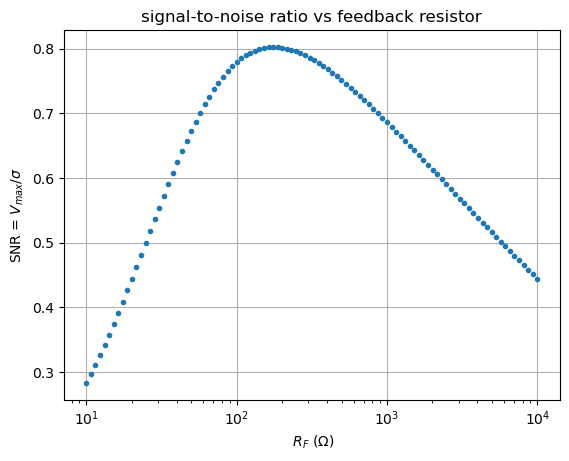

The best result is:
Output pulse height over baseline stdev is 0.80 at R_F = 174.8 Ω
Feedback Capacitance is 264.50 pF at R_F = 174.8 Ω
-3dB Bandwidth is 4.87 MHz at R_F = 174.8 Ω


In [18]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# 参数定义
n_SiPM = 2  # 并联的SiPM数量
R_F_values = np.logspace(1, 4, 100)  # 计算反馈电阻的范围（Ω）
C_extra = (250 + 300) * 1e-12  # 额外附加的电容（F）
tau_crystal = 70e-9  # 闪烁体发光衰减时间（s）
extra_DCR = 0  # 附加的暗计数率（Hz）

# 常数定义
e = 1.6e-19  # 元电荷（C）
k = 1.38e-23  # 玻尔兹曼常数（J/K）
T = 300  # 温度（K）

# 运放参数
omega_A = 2 * np.pi * opamp.GBP / opamp.A_OL  # 运放开环增益的带宽（rad/s）

# 输入端总电容（F）
C_PCB = 0.3e-12
C_D = n_SiPM * sipm.C_SiPM + C_PCB + opamp.C_CM + opamp.C_DIFF + C_extra

# 单光子电荷量（C）
Q = sipm.gain * e

# 总暗计数率（Hz）
DCR_total = n_SiPM * sipm.area * 1e6 * sipm.DCR_mm2 + extra_DCR  # 注意面积单位转换

sys_Crystal = signal.TransferFunction([1], [tau_crystal, 1]) # 闪烁体传递函数
sys_SiPM = signal.TransferFunction([1], [sipm.t_fall, 1]) # SiPM传递函数

# 仿真时间参数
dT = 1e-9  # 时间步长（s）
t = np.arange(0, 3e-6 + dT, dT)  # 时间序列（s）

# 初始化结果存储数组
num_R_F = len(R_F_values)
resp_total = np.zeros((num_R_F, len(t)))  # 系统冲激响应
C_F = np.zeros(num_R_F)  # 反馈电容值
f_3dB = np.zeros(num_R_F)  # -3dB带宽
V_max = np.zeros(num_R_F)  # 最大输出电压
Vn_TIA = np.zeros(num_R_F)  # TIA电子噪声电压
Vn_DC = np.zeros(num_R_F)  # 暗计数噪声电压
SNR = np.zeros(num_R_F)  # 信噪比

# 主计算循环
for i, R_F in enumerate(R_F_values):
    # 系统响应分析
    C_F[i] = np.sqrt(C_D / (opamp.GBP * np.pi * R_F))  # 反馈电容（F）
    f_3dB[i] = np.sqrt(opamp.GBP / (2 * np.pi * R_F * C_D))  # -3dB带宽（Hz）
    omega = 2 * np.pi * f_3dB[i]  # 角频率（rad/s）
    Q_value = omega / (omega_A + np.sqrt(2) * omega + 1 / (R_F * C_D))  # 品质因数
    sys_TIA = signal.TransferFunction([omega**2], [1, omega / Q_value, omega**2])  # TIA传递函数
    sys_total = sys_TIA * sys_SiPM * sys_Crystal  # 系统总传递函数
    _, resp = signal.impulse(sys_total, T=t)  # 计算系统冲激响应
    resp_total[i, :] = resp
    I_max = Q * np.max(resp)  # 最大输出电流（A）
    V_max[i] = I_max * R_F  # 最大输出电压（V）

    # 噪声计算
    F = f_3dB[i]  # 噪声有效带宽（Hz）
    I_OUTN = np.zeros(4)  # 噪声贡献（A^2/Hz）
    I_OUTN[0] = opamp.I_N**2  # 运放输入电流噪声
    I_OUTN[1] = 4 * k * T / R_F  # 反馈电阻热噪声
    I_OUTN[2] = (opamp.E_N / R_F)**2  # 运放输入电压噪声
    I_OUTN[3] = (opamp.E_N * 2 * np.pi * C_D * F)**2 / 3  # 输入电容相关噪声
    I_en2 = np.sum(I_OUTN) * F  # 总输入参考电流噪声（A^2）
    Vn_TIA[i] = np.sqrt(I_en2) * R_F  # TIA电子噪声电压（V）
    sigma2 = DCR_total * Q**2 * np.sum(resp**2) * dT  # 噪声电流方差（A^2）
    Vn_DC[i] = np.sqrt(sigma2) * R_F  # 暗计数噪声电压（V）

    # 信噪比计算
    total_noise_variance = sigma2 + I_en2  # 总噪声方差（A^2）
    SNR[i] = I_max / np.sqrt(total_noise_variance)  # 信噪比

# 结果绘制
plt.figure()
plt.semilogx(R_F_values, SNR, '.')
plt.xlabel(' $R_F$ (Ω)')
plt.ylabel('SNR = $V_{max} / σ$')
plt.title('signal-to-noise ratio vs feedback resistor')
plt.grid(True)
plt.show()

# 寻找最佳反馈电阻值
SNR_max = np.max(SNR)  # 找到最大信噪比及对应的索引
best_index = np.argmax(SNR)
best_R_F = R_F_values[best_index]

# 输出对应最大信噪比的参数
print('The best result is:')
print(f'Output pulse height over baseline stdev is {SNR_max:.2f} at R_F = {best_R_F:.1f} Ω')
print(f'Feedback Capacitance is {C_F[best_index]*1e12:.2f} pF at R_F = {best_R_F:.1f} Ω')
print(f'-3dB Bandwidth is {f_3dB[best_index]/1e6:.2f} MHz at R_F = {best_R_F:.1f} Ω')